## Importing the data

In this section, we upload the three datasets that will be used and integrated to create the comprehensive dataset required for the final analyses. 

- **'pilot_results'**: results from the pilot experiment, with information on the median values of the videos
- **'exp_results'** : results from the main experiment
- **'actors_info'**: information about the actors and corresponding videos


In [5]:
# Import of libraries and functions

# Standard libraries
import os

# Data handling
import pandas as pd 
import numpy as np

# Statistics
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory - change according to one own's directory
assign_directory = '/Users/Ilaria/Library/CloudStorage/GoogleDrive-ilaria.mirlisenna@unitn.it/Il mio Drive/Lessons/Python/final assignement/'

# Loading data
pilot_results = pd.read_excel(os.path.join (assign_directory, 'pilot_results.xlsx'))
exp_results = pd.read_excel(os.path.join (assign_directory, 'experimental_results.xlsx'))
actors_info = pd.read_excel(os.path.join (assign_directory, 'videos_info.xlsx', usecols = "A:C"))


## Visual check of the datasets

Here, we visualize the first rows of each dataset to confirm that the correct files have been loaded

In [66]:
# Checking that the correct files have been loaded

print('Experimental results:')
display(exp_results.head())

print('Pilot results:')
display(pilot_results)

print('Actors info:')
display(actors_info.head())

Experimental results:


,subjID,gender,age,condition,video,trial,painInitial,Painfinal,Paintime,Realinitial,Realfinal,Realtime,pilot median pain,pilot_median_reality,dots median,dots std,mu target,Uncertainty,Simulation,Actor
0,1,F,29,B,HRP female5,1,8,48,4.106242,8,27,3.736483,76,80.0,86.0,5.0,86,Low,Real,subject 5
1,1,F,29,C,HPP Males2,2,89,78,3.621247,9,18,3.146609,70,47.0,60.0,15.0,60,High,Posed,subject 17
2,1,F,29,B,LPP female19,3,66,17,4.372672,41,16,3.302117,30,61.5,40.0,5.0,40,Low,Posed,subject 14
3,1,F,29,A,HPP female7,4,76,48,4.587831,6,32,6.894872,65,69.5,75.0,15.0,75,High,Posed,subject 11
4,1,F,29,B,HPP female13,5,93,93,1.672954,71,22,4.360041,63,73.0,73.0,5.0,73,Low,Posed,subject 2


Pilot results:


,Subj_ID,Gender,Age,Folder,Video,PainInitial,PainFinal,PainTime(s),RealInitial,RealFinal,RealTime(s)
0,1,F,23,A,N female 47.mp4,39,1,5.504070,999,999,999.000000
1,1,F,23,A,HRP female 6.mp4,90,4,6.374260,69,19,6.361051
2,1,F,23,A,LRP female 9.mp4,83,11,12.908778,77,22,4.823551
3,1,F,23,A,LPP female 6.mp4,60,26,4.112881,70,1,7.141504
4,1,F,23,A,HRP Males 11.mp4,38,44,4.413016,42,80,4.488369
...,...,...,...,...,...,...,...,...,...,...,...
1320,20,f,28,B,LRP Males 5.mp4,77,42,2.241601,39,35,1.192649
1321,20,f,28,B,HRP female 14.mp4,12,51,13.599626,3,59,2.966122
1322,20,f,28,B,N Males 18.mp4,98,60,2.752098,999,999,999.000000
1323,20,f,28,B,HPP female 4.mp4,68,81,1.941841,72,22,2.381840


Actors info:


,SUBJ,Median,std
0,subject 1,NaN,NaN
1,HPP female8,63.0,24.0
2,HRP female8,71.0,30.0
3,subject 2,NaN,NaN
4,HPP female13,63.0,18.0


## Calculating Median Scores per Video

In this section, we compute the median values from the measures of interest ('PainFinal' and 'RealFinal') for each video starting from the pilot results. 
This allows to later link these median values to the corresponding videos in the experimental results and use them as reference point for the analyses

In [42]:
# Calculating the median values for the measures of interest for each video

# identify all the videos
videos = pilot_results['Video'].unique()

# initialize an empty list where i am gonna put the measures of interest 
table_median = []

for video in videos:
    curr_video = pilot_results[pilot_results['Video'] == video]
    table_median.append({
        'Video': video.replace('.mp4', ''),
        'MedianPainFinal': np.median(curr_video['PainFinal']),
        'MedianRealFinal': np.median(curr_video['RealFinal'])})

# create a dataframe out of the list
table_median = pd.DataFrame(table_median)
table_median_sorted =  table_median.sort_values(by='Video')

# rename the videos to match the names in the results doc
table_median['Video'] = table_median['Video'].str.replace('Males ', 'Males')
table_median['Video'] = table_median['Video'].str.replace('female ', 'female')


## Building an Actor-Video table

Here, we create a table that links each actor to their corresponding posed and real videos.
Starting from the original "actors_info" dataset, we loop through the table and whenever we find a row containing "subject", we take the next two rows as the posed and real videos.
Next, we create an organized and clean table that contains the columns "Actor", "Posed_Video" and "Real_Video", which allows us to easily identify which actor performed in each video used during the experiment.

In [14]:
# Linking the video names to the actor who performed them

# initialize an empty list
temporary_rows = []

# create an organized table that contains for each row the name of the actor and the corresponding posed and real videos
for i in range(len(actors_info) - 2):
    if "subject" in str(actors_info.loc[i, "SUBJ"]):
        curr_subj = actors_info.loc[i, "SUBJ"]
        curr_posed = actors_info.loc[i + 1, "SUBJ"]
        curr_real = actors_info.loc[i + 2, "SUBJ"]
        
        temporary_rows.append({"Actor": curr_subj, "Posed_Video": curr_posed, "Real_Video": curr_real})

t_actor_names = pd.DataFrame(temporary_rows)

# check if everything is ok
print('Actors info organized:')
display(t_actor_names.head())

,Actor,Posed_Video,Real_Video
0,subject 1,HPP female8,HRP female8
1,subject 2,HPP female13,HRP female12
2,subject 3,HPP female10,HRP female11
3,subject 5,HPP female4,HRP female5
4,subject 6,HPP female1,HRP female1
5,subject 7,HPP female3,HRP female4
6,subject 8,LPP female6,LRP female7
7,subject 9,HPP female14,HRP female13
8,subject 10,HPP female9,HRP female9
9,subject 11,HPP female7,HRP female7


# Building the comprehensive experimental database for the analyses

In this section, we combine the different information to obtain a comprehensive dataset with all the information needed for the analyses. 

Steps include:
1. Initializing an empty dataframe and adding core experimental information
2. Adding and deriving information about the Actor performing each video
3. Adding additional experimental information to be used as predictors or dependant variables in later analyses 

In [64]:
# initialize an empty database for comprehensive analyses
database = pd.DataFrame()

# print the experimental results dataset to keep track of the information to add
print('Print the experimental results dataset to keep track of the information to add:')
display(exp_results.head())

# add core information from the experimental results dataset
database['Subject_ID'] = exp_results['subjID']
database['Trial'] = exp_results['trial']
database['SubjGender'] = exp_results['gender']

# initialize an empty column for storing the actor performing each video
database['Actor'] = None

# link each video in exp_results to the corresponding actor
for i, row in exp_results.iterrows():
    curr_video = row['video']
    is_match = (t_actor_names[['Posed_Video', 'Real_Video']] == curr_video).any(axis = 1)
    curr_actor = t_actor_names.loc[is_match, 'Actor']

    if not curr_actor.empty:
            exp_results.loc[i, 'Actor'] = curr_actor.iloc[0]
    else:
            exp_results.loc[i, 'Actor'] = None

# add information about the actor and the video        
database['Actor'] = exp_results['Actor']
database['Face_ID'] = exp_results['video']

# derive the gender of the actor performing the video
database['Actor_Gender'] = np.where(database['Face_ID'].str.contains('female'), 'F', np.where(database['Face_ID'].str.contains('Males'), 'M', None))

# add additional information from the experimental results dataset
database['Simulation'] = exp_results['Simulation']
database['MU_VideoPain'] = exp_results['pilot median pain']

# assign median value for the Reality scores 
mu_reality_list = []

for i, row in exp_results.iterrows():
    curr_video = row['video']
    is_match = table_median[table_median['Video'] == curr_video.replace('.mp4', '')]
    if not is_match.empty:
        mu_reality_list.append(is_match['MedianRealFinal'].values[0])
    else:
        mu_reality_list.append(np.nan)


database['MU_VideoReality'] = mu_reality_list

# add missing information 
database['Target_cue_mean'] = exp_results['mu target']
database['Actual_cue_mean'] = exp_results['dots median']
database['Uncertainty'] = exp_results['Uncertainty']
database['Actual_cue_std'] = exp_results['dots std']
database['PainFinal'] = exp_results['Painfinal']
database['Pain_RT'] = exp_results['Paintime']
database['Pain_Path'] = exp_results['Painfinal'] - exp_results['painInitial']
database['VerFinal'] = exp_results['Realfinal']
database['Ver_rt'] = exp_results['Realtime']
database['Ver_Path'] = exp_results['Realfinal'] - exp_results['Realinitial']

# add difference between actual cue mean and video pain median
database['ExpIntDiff'] = database['Actual_cue_mean'] - database['MU_VideoPain'] 

# categorize Expectancy Effect
database['Expectancy'] = np.where(database['ExpIntDiff'] > 0, 'High', 'Low')

# show if the database is okay
print('Check the final dataset:')
display(database.head())

print the experimental results dataset to keep track of the information to add:


,subjID,gender,age,condition,video,trial,painInitial,Painfinal,Paintime,Realinitial,Realfinal,Realtime,pilot median pain,pilot_median_reality,dots median,dots std,mu target,Uncertainty,Simulation,Actor
0,1,F,29,B,HRP female5,1,8,48,4.106242,8,27,3.736483,76,80.0,86.0,5.0,86,Low,Real,subject 5
1,1,F,29,C,HPP Males2,2,89,78,3.621247,9,18,3.146609,70,47.0,60.0,15.0,60,High,Posed,subject 17
2,1,F,29,B,LPP female19,3,66,17,4.372672,41,16,3.302117,30,61.5,40.0,5.0,40,Low,Posed,subject 14
3,1,F,29,A,HPP female7,4,76,48,4.587831,6,32,6.894872,65,69.5,75.0,15.0,75,High,Posed,subject 11
4,1,F,29,B,HPP female13,5,93,93,1.672954,71,22,4.360041,63,73.0,73.0,5.0,73,Low,Posed,subject 2


Check the final dataset:


,Subject_ID,Trial,SubjGender,Actor,Face_ID,Actor_Gender,Simulation,MU_VideoPain,MU_VideoReality,Target_cue_mean,Actual_cue_mean,Uncertainty,Actual_cue_std,PainFinal,Pain_RT,Pain_Path,VerFinal,Ver_rt,Ver_Path,ExpIntDiff,Expectancy
0,1,1,F,subject 5,HRP female5,F,Real,76,76.0,86,86.0,Low,5.0,48,4.106242,40,27,3.736483,19,10.0,High
1,1,2,F,subject 17,HPP Males2,M,Posed,70,35.0,60,60.0,High,15.0,78,3.621247,-11,18,3.146609,9,-10.0,Low
2,1,3,F,subject 14,LPP female19,F,Posed,30,65.5,40,40.0,Low,5.0,17,4.372672,-49,16,3.302117,-25,10.0,High
3,1,4,F,subject 11,HPP female7,F,Posed,65,72.5,75,75.0,High,15.0,48,4.587831,-28,32,6.894872,26,10.0,High
4,1,5,F,subject 2,HPP female13,F,Posed,63,70.0,73,73.0,Low,5.0,93,1.672954,0,22,4.360041,-49,10.0,High


## Running Linear Mixed Models 

In this section, we implement different linear mixed models to analyze participants' pain and reality ratings while accounting for repeated measures within subjects. 

Specifically, models include:

### Dependent variables
   - 'PainFinal': final pain ratings
   - 'VerFinal': final reality ratings
     
### Predictors
   - Main predictors: 'Expectancy' (High vs Low), 'Simulation' (Real vs Posed), 'Uncertainty' (High vs Low)
   - Additional factor: 'ActorGender': Male vs Female
     
### Random effects
   - All models include 'Subject_ID' as a random intercept to account for repeated measures

### Models structure
  1. **Basic models**
     Fit a mixed linear model with 'Expectancy * Simulation * Uncertainty' as fixed effects and random intercepts for subjects      for each dependent variable
  2. **Extended models**
     Extend the basic models by adding 'ActorGender' and its interactions with other predictors. 


In [87]:
# running a mixed model for Pain Final 
print("\n--- Pain Results ---")
model_pain = mixedlm("PainFinal ~ Expectancy * Simulation * Uncertainty", database, groups=database["Subject_ID"])
result_pain = model_pain.fit()
print(result_pain.summary())

# running a mixed model for Real Final 
print("\n--- Reality Results ---")
model_real = mixedlm("VerFinal ~ Expectancy * Simulation * Uncertainty", database, groups=database["Subject_ID"])
result_real = model_real.fit()
print(result_real.summary())

# running a mixed model for Pain Final adding ActorGender
print("\n--- Pain Results with ActorGender ---")
model_pain_actor = mixedlm("PainFinal ~ Expectancy * Simulation * Uncertainty * Actor_Gender", database, groups=database["Subject_ID"], re_formula="~1")
result_pain_actor = model_pain_actor.fit(method = "powell")
print(result_pain_actor.summary())

# running a mixed model for Pain Final adding ActorGender
print("\n--- Reality Results with ActorGender ---")
model_real_actor = mixedlm("VerFinal ~ Expectancy * Simulation * Uncertainty * Actor_Gender", database, groups=database["Subject_ID"], re_formula="~1")
result_real_actor = model_real_actor.fit(method = "powell")
print(result_real_actor.summary())



--- Pain Results ---
                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               PainFinal 
No. Observations:               1680                  Method:                           REML      
No. Groups:                     30                    Scale:                            723.2303  
Min. group size:                56                    Log-Likelihood:                   -7920.1779
Max. group size:                56                    Converged:                        Yes       
Mean group size:                56.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept          

## Plotting the data

In this section, we visually explore how participants' ratings vary across the experimental conditions. 

- Boxplots are used to show the distribution of pain ('PainFinal') and reality ('VerFinal') ratings across levels of 'Expectancy', 'Uncertainty' and 'Simulation'
- A Pointplot highlights the significant interaction between 'Simulation' and 'Actor_Gender' in the reality ('VerFinal') ratings

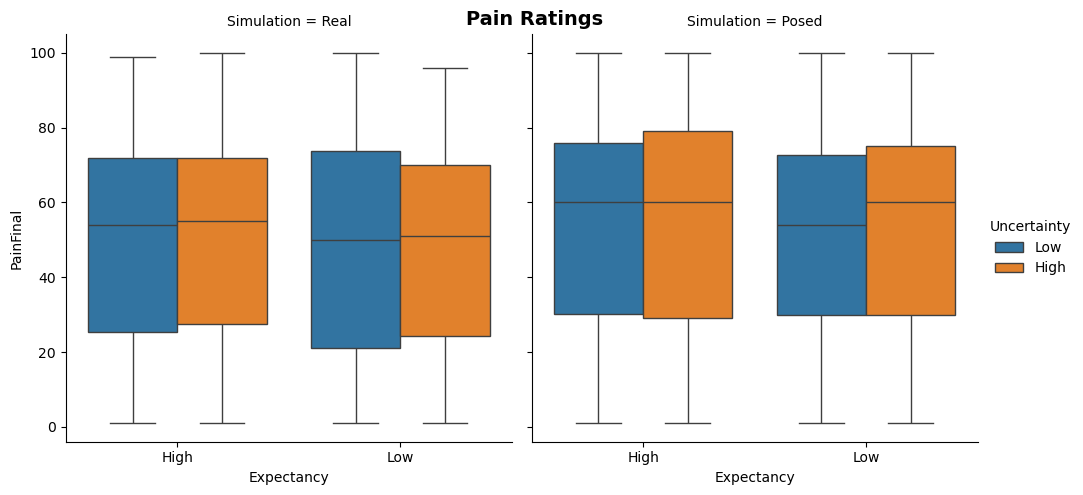

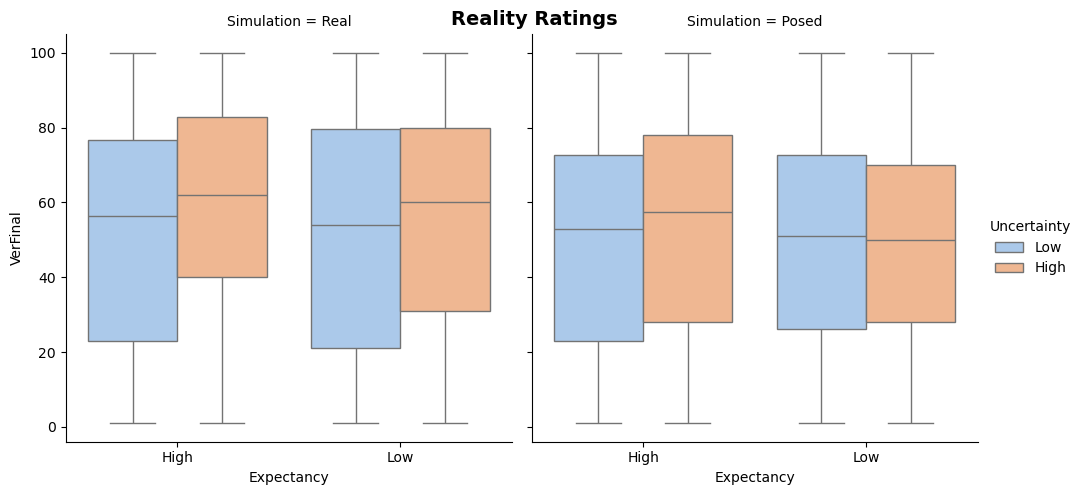

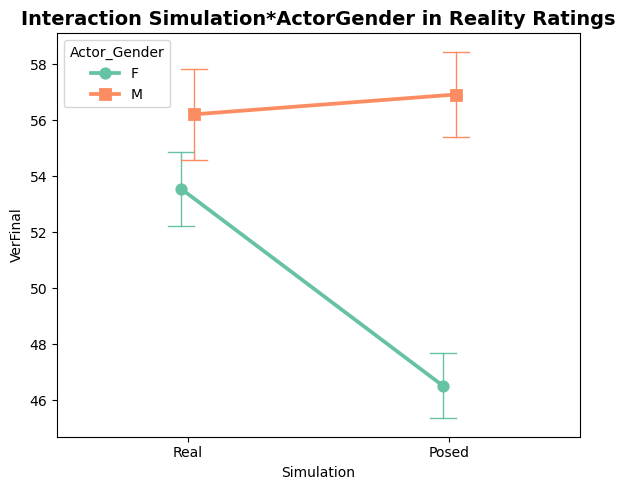

In [126]:

# PainFinal boxplots
figure_pain = sns.catplot(data = database, x = 'Expectancy', y = 'PainFinal', hue = 'Uncertainty', col = 'Simulation', kind = 'box', height = 5, aspect = 1)
figure_pain.fig.suptitle("Pain Ratings", fontsize = 14, weight = "bold")

# VerFinal boxplots
figure_reality = sns.catplot(data = database, x = 'Expectancy', y = 'VerFinal', hue = 'Uncertainty', col = 'Simulation', kind = 'box', height = 5, aspect = 1, palette = "pastel")
figure_reality.fig.suptitle("Reality Ratings", fontsize = 14, weight = "bold")

# Exploring the significant interaction Simulation*ActorGender in Reality Ratings
plt.figure(figsize=(6,5))

interaction_plot = sns.pointplot(data = database, x = "Simulation", y = "VerFinal", hue = "Actor_Gender", dodge = True, markers= ["o", "s"], capsize = .1, err_kws={'linewidth': 1}, errorbar = "se",palette="Set2")
interaction_plot.set_title("Interaction Simulation*ActorGender in Reality Ratings", fontsize = 14, weight = "bold")

plt.tight_layout()
plt.show()